In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("diabetes_dataset.csv")
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


ill_glucose = (df["Glucose"]<44)
ill_bp = ((df["BloodPressure"]<40) | (df['BloodPressure']>120))
ill_BMI = (df["BMI"]==0)
ill_ST = (((df["SkinThickness"]<10) & (df["SkinThickness"]>0)) | (df["SkinThickness"]>50))
ill_insulin = (df["Insulin"]>400)

df["Removed"] = (ill_glucose | ill_bp | ill_BMI | ill_ST | ill_insulin)



In [17]:
df_valid = df[(df["Removed"]==False)]
cols = ['SkinThickness', 'Insulin']
df_valid[cols]=df_valid[cols].replace(0,np.nan)
medians = df_valid.groupby('Type')[cols].median()
medians_map = medians.to_dict()
for it in cols:
    df_valid[it] = np.where((df_valid[it].isnull()),df_valid["Type"].map(medians[it]),df_valid[it])



C:\Users\saran\AppData\Local\Temp\ipykernel_19352\3365838955.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid[cols]=df_valid[cols].replace(0,np.nan)
C:\Users\saran\AppData\Local\Temp\ipykernel_19352\3365838955.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid[it] = np.where((df_valid[it].isnull()),df_valid["Type"].map(medians[it]),df_valid[it])
C:\Users\saran\AppData\Local\Temp\ipykernel_19352\3365838955.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [18]:
feature_cols = [it for it in df_valid.columns if it not in ["Outcome","Type","Removed"]]

train_df = df_valid[df_valid["Type"]=="train"]

X_train = train_df[feature_cols].to_numpy()
Y_train = train_df["Outcome"].to_numpy()

mu_train = np.mean(X_train,axis=0)
std_train = np.std(X_train,axis=0)
D_sigma_inv_train = np.diag(1/std_train)

X_train_scaled = (X_train-mu_train) @ D_sigma_inv_train

X_1tr = np.hstack([np.ones((X_train_scaled.shape[0],1)),X_train_scaled])
Y_tr = Y_train

Beta = np.zeros((X_1tr.shape[1],1))

def sigmoid(z):
    return 1/(1+np.exp(-z))



In [19]:
iteration = 0
likelihoood_iterations=[]
while True:
    P = sigmoid(X_1tr @ Beta)
    W = np.diag((P*(1-P)).flatten())
    gradient = X_1tr.T @ (Y_tr.reshape(-1,1)-P)
    Delta =  np.linalg.inv(X_1tr.T @ W @ X_1tr) @ gradient
    Beta = Beta + Delta
    iteration=iteration+1
    
    P_temp = P.reshape(-1,1)
    Y_temp = Y_tr.reshape(-1,1)
    likelihood_vector = (P_temp**Y_temp)*((1-P_temp)**(1-Y_temp))
    likelihoood_iterations.append(likelihood_vector.flatten())

    if np.linalg.norm(Delta)<0.000001 and iteration>20:
        print("Converged")
        break

    # print(f"Iteration completed {iteration}",end = "\r",flush=True)




Converged


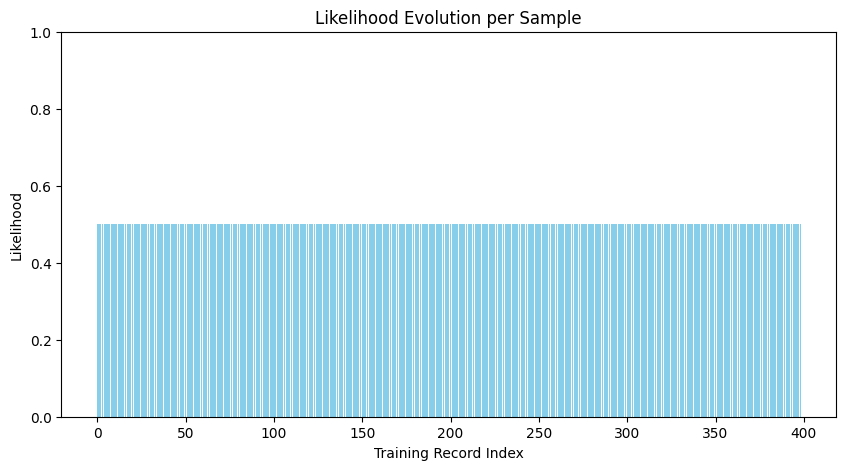

In [20]:

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

iterations = len(likelihoood_iterations)
likelihood_size = likelihoood_iterations[0].size

xaxis = np.arange(likelihood_size)

fig,ax = plt.subplots(figsize=(10,5))
bars = ax.bar(xaxis,likelihoood_iterations[0],color="skyblue")
ax.set_ylim(0,1)
ax.set_xlabel("Training Record Index")
ax.set_ylabel("Likelihood")
ax.set_title("Likelihood Evolution per Sample")
def update(frame):
    for bar, new_height in zip(bars, likelihoood_iterations[frame]):
        bar.set_height(new_height)
    ax.set_title(f"Iteration {frame+1}")
    return bars

anim = FuncAnimation(fig, update, frames=iterations, interval=500, blit=False, repeat=True)
plt.show()
HTML(anim.to_jshtml())

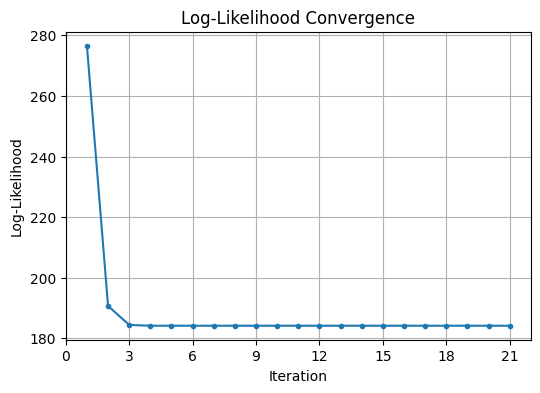

In [21]:
likelihoood_iterations=np.vstack(likelihoood_iterations)
log_likelihoods = np.sum(np.log(likelihoood_iterations + 1e-12)*-1, axis=1)
fig2, ax2 = plt.subplots(figsize=(6, 4))
ax2.plot(range(1, iterations + 1), log_likelihoods, marker='.')
ax2.set_xlabel("Iteration")
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_ylabel("Log-Likelihood")
ax2.set_title("Log-Likelihood Convergence")
ax2.grid(True)
plt.show()